<a href="https://colab.research.google.com/github/karthiqak47/DSP_Learning/blob/main/DSP_LAB_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.Import sample audio

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import correlate
 # Read the wav file
rate, y_in = wavfile.read("/content/sample_tone_440Hz[1].wav")
y_in = y_in.astype(float) / 32767 # Convert to float for processing

print(f"PTQ1: The maximum value of the audio sample present in the file is {np.max(y_in)}")
print(f"PTQ2: The minimum value of the audio sample present in the file is {np.min(y_in)}")
print(f"PTQ3: The total length of the audio sample is {len(y_in)}")





PTQ1: The maximum value of the audio sample present in the file is 0.499984740745262
PTQ2: The minimum value of the audio sample present in the file is -0.499984740745262
PTQ3: The total length of the audio sample is 88200


# 2. Plot Autocorrelation

Autocorrelation length: 176399
Lags range: -88199 to 88199


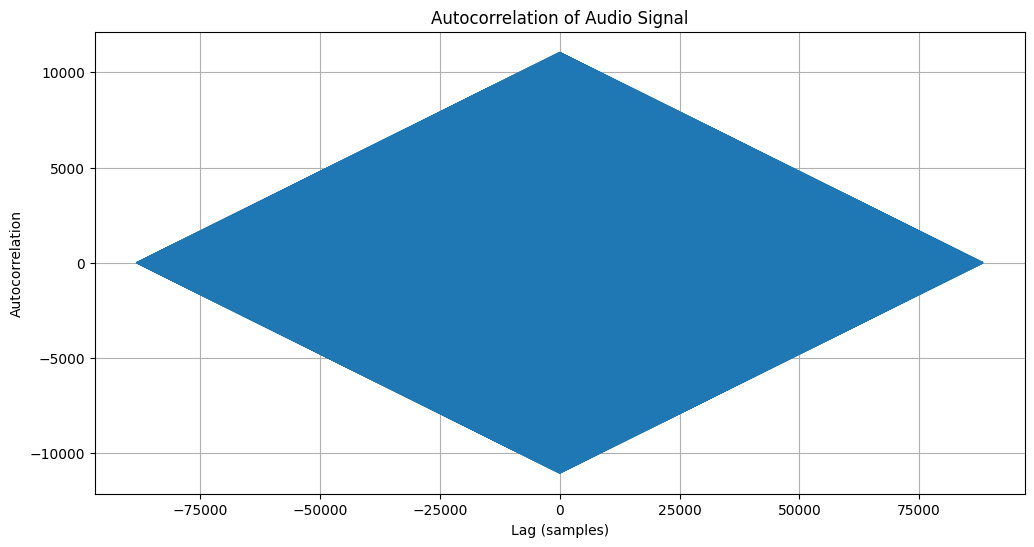

Global peak at lag = 0


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import correlate
from scipy.io import wavfile

# Step 1: Compute Autocorrelation
autocorr = correlate(y_in, y_in, mode='full')
lags = np.arange(-len(y_in)+1, len(y_in))


print(f"Autocorrelation length: {len(autocorr)}")
print(f"Lags range: {lags[0]} to {lags[-1]}")

# Step 2: Plot the autocorrelation
plt.figure(figsize=(12, 6))
plt.plot(lags, autocorr)
plt.title('Autocorrelation of Audio Signal')
plt.xlabel('Lag (samples)')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()

peak_index = np.argmax(autocorr)  # Index of global max (at lag = 0)
print(f"Global peak at lag = {lags[peak_index]}")






# 3.Second Peak of autocorrelation

Second peak at lag = 100 (estimated delay)
Index:: 88299


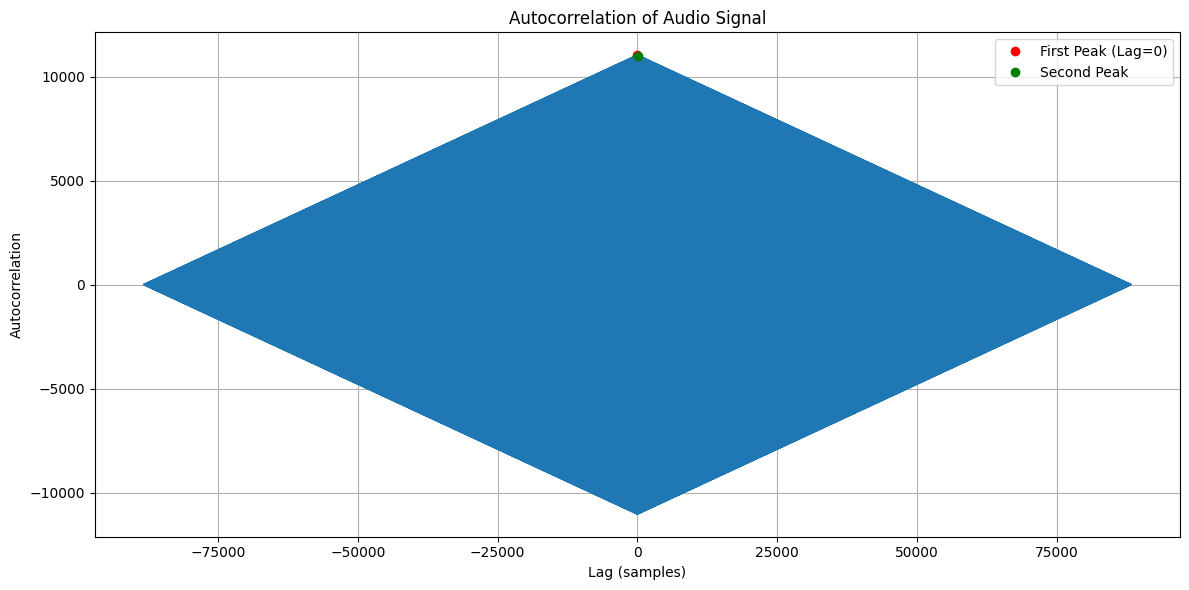

11024.145292790374


In [ ]:
second_peak_index = np.argmax(autocorr[peak_index+1:]) + peak_index + 1
d_delay = lags[second_peak_index]
print(f"Second peak at lag = {d_delay} (estimated delay)")
print(f"Index:: {second_peak_index }")

# Step 3: Plot the autocorrelation
plt.figure(figsize=(12, 6))
plt.plot(lags, autocorr)
plt.plot(lags[peak_index], autocorr[peak_index], 'ro', label='First Peak (Lag=0)')
plt.plot(lags[second_peak_index], autocorr[second_peak_index], 'go', label='Second Peak')
plt.title('Autocorrelation of Audio Signal')
plt.xlabel('Lag (samples)')
plt.ylabel('Autocorrelation')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
print(autocorr[peak_index] )

# 4.Estimated Attenuation

In [ ]:
import numpy as np

# Function to estimate attenuation using projection
def estimate_attenuation(y_signal, d_delay):

    y_delayed = np.roll(y_signal, d_delay)
    numerator = np.dot(y_signal, y_delayed)
    denominator = np.dot(y_delayed, y_delayed)
    if denominator == 0:
        return 0
    return numerator / denominator


estimated_alpha = estimate_attenuation(y_in, d_delay)
print(f"Estimated Attenuation (α): {estimated_alpha:.4f}")


Estimated Attenuation (α): 0.9999


# 5.Echo Removal

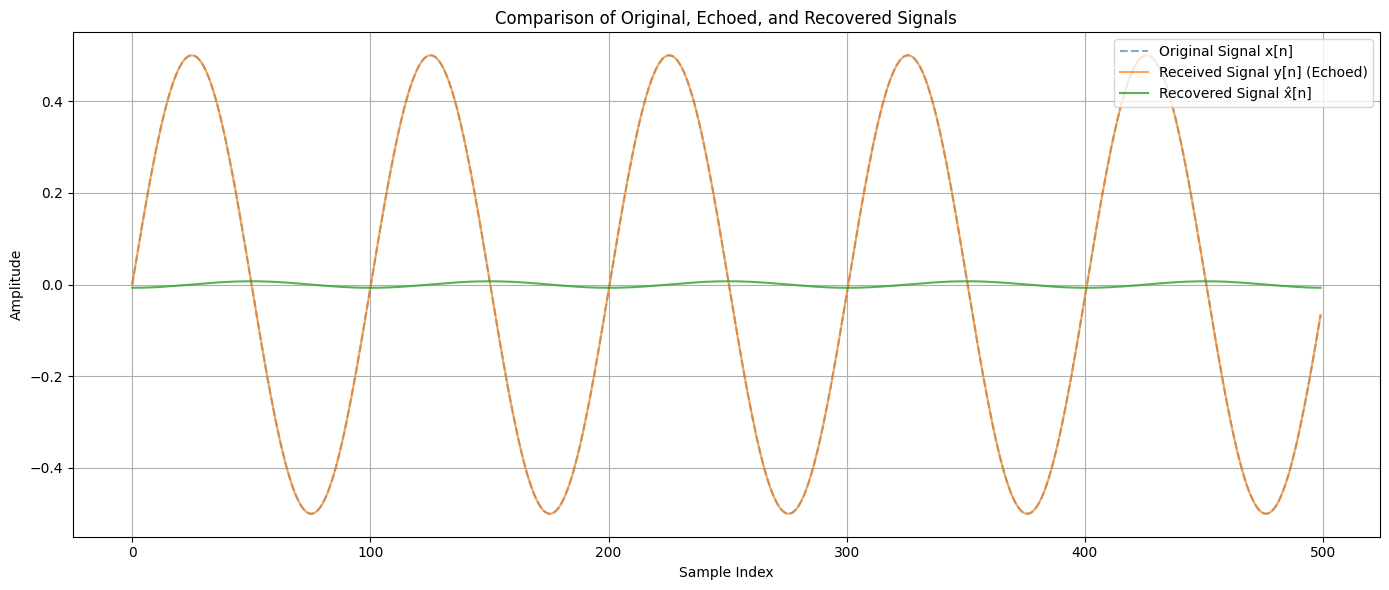

Estimated Delay (D): 100 samples
Estimated Attenuation (α): 0.9999


In [ ]:
estimated_alpha = estimate_attenuation(y_in, d_delay)
e_echo = np.roll(y_in, d_delay)         # Delay
estimated_echo = estimated_alpha * e_echo       # Scale by α
x_hat = y_in - estimated_echo
rate, x = wavfile.read("/content/sample_tone_440Hz[1].wav")
x = x.astype(float) / 32767


plt.figure(figsize=(14, 6))
plt.plot(x[:500], label='Original Signal x[n]', linestyle='dashed', alpha=0.6)
plt.plot(y_in[:500], label='Received Signal y[n] (Echoed)', alpha=0.7)
plt.plot(x_hat[:500], label='Recovered Signal x̂[n]', alpha=0.8)
plt.title("Comparison of Original, Echoed, and Recovered Signals")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



print(f"Estimated Delay (D): {d_delay} samples")
print(f"Estimated Attenuation (α): {estimated_alpha:.4f}")

# 6.Time Reversal property

In [ ]:
from numpy.fft import fft


N = len(y_in)
Y = fft(y_in)
y_in_rev = y_in.copy()
y_in_rev[1:] = y_in[1:][::-1]

Y = fft(y_in)
Y_N_refl_shift = Y.copy()
Y_N_refl_shift[1:] = Y[1:][::-1]

Y_rev = fft(y_in_rev)

verification_err = np.sum(np.abs(Y_rev - Y_N_refl_shift) ** 2)
print("Error:", verification_err)






Error: 2.129757581245839e-22


# 7.Circular Time Shift Property

In [ ]:
from numpy.fft import fft
import numpy as np

n0 = 12  # shift amount
N = len(y_in)
k = np.arange(N)


y_in_shifted = np.roll(y_in, n0)
Y_shifted_dft = fft(y_in_shifted)

Y = fft(y_in)  # DFT of original signal
Y_expected_shift_dft = Y * np.exp(-1j * 2 * np.pi * k * n0 / N)


verification_err_shift = np.sum(np.abs(Y_shifted_dft - Y_expected_shift_dft)**2 )
print(f"Verification error (Circular Time Shift Property): {verification_err_shift:.4e}")


Verification error (Circular Time Shift Property): 7.8319e-21


# Frequency Shift Property

In [ ]:
from numpy.fft import fft
import numpy as np

k0 = 3
N = len(y_in)
n = np.arange(N)

y_in_freq_shifted = y_in * np.exp(1j * 2 * np.pi * k0 * n / N)
Y_freq_shifted = fft(y_in_freq_shifted)

Y = fft(y_in)
Y_expected_freq_shift = np.roll(Y, k0)

verification_err_freq = np.sum(np.abs(Y_freq_shifted - Y_expected_freq_shift) ** 2)
print("Verification error (Frequency Shift Property):",verification_err_freq)


Verification error (Frequency Shift Property): 7.1778290511385515e-22


# Circular Convolution Property

In [ ]:
import numpy as np
from numpy.fft import fft, ifft


def circular_convolution(x, h):
    N = len(x)
    return np.real(ifft(fft(x) * fft(h)))


N = len(y_in)
h = np.random.randn(N)


Y_in = fft(y_in)
H = fft(h)
y_circ = ifft(Y_in * H)


y_circ_direct = circular_convolution(y_in, h)


verification_err_circ = np.sum(np.abs(y_circ - y_circ_direct) ** 2)
print(f"Verification error (Circular Convolution Property): {verification_err_circ:.4e}")


Verification error (Circular Convolution Property): 8.5247e-23


# 7. Manual circular convolution vs ifft of products of fft

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import correlate


x = y_in[:1024]
N = len(x)
h = np.random.randn(N)
Y = np.fft.fft(x)H = np.fft.fft(h)
y_circ = np.fft.ifft(Y * H)


def circular_convolution(x, h):
    N = len(x)
    y = np.zeros(N)
    for i in range(N):
        for j in range(N):
            y[i] += x[j] * h[(i - j) % N]
    return y

y_circ_direct = circular_convolution(x, h)

verification_err = np.sum(np.abs(y_circ - y_circ_direct) ** 2)
print(f"Verification error (Circular Convolution): {verification_err:.4e}")


Verification error (Circular Convolution): 9.0829e-26
